In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Active Directory** Must be TPL-Loss-Work



In [2]:
%cd '/content/drive/MyDrive/ChangTextSR/26FebOnwar/26febOnNBS/TPL-Loss-Work'

/content/drive/.shortcut-targets-by-id/1J9__WJ-rS1-X0IbbGlVPSfYydhyOm7Sm/ChangTextSR/26FebOnwar/26febOnNBS/TPL-Loss-Work


In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import torchvision 
import cv2
import sys
from mpl_toolkits.axes_grid1 import ImageGrid
import json

## Might be helpful Later

In [ ]:
root_path = 'book/'
img_names = []
for img_name in img_names_w:
    img_names.append(root_path+img_name)

In [ ]:
def create_patches(img_path,crop_size):
  img = Image.open(img_path)
  img = torchvision.transforms.Grayscale(num_output_channels=1)(img)
  img = torchvision.transforms.CenterCrop((2048,692*2))(img)
  img = torchvision.transforms.ToTensor()(img)
  padding = (((img.shape[1]//crop_size)*crop_size)-img.shape[-1])//2
  img = torchvision.transforms.functional.pad(img,[padding,0,padding,0],fill=0)
  sub_images = []
  for i in range(8):
    sub_images_r = []
    for j in range(8):
      sub_images_r.append(img[:,i*crop_size:(i+1)*crop_size,j*crop_size:(j+1)*crop_size])
    sub_images.append(sub_images_r)
  return sub_images

In [ ]:
def plot_grid(img_p):
    fig = plt.figure(figsize=(20,20))
    images = []
    for img_r in img_p:
      for img in img_r:
        images.append(img)
    grid = ImageGrid(fig,111,nrows_ncols=(8,8),axes_pad=0.1)
    for ax,im in zip(grid,images):
        ax.imshow(im.squeeze(0),cmap='gray')

In [ ]:
#Pattch Size is 256, just for testing, coulb be any
img_p = create_patches(img_names[0],128*2)

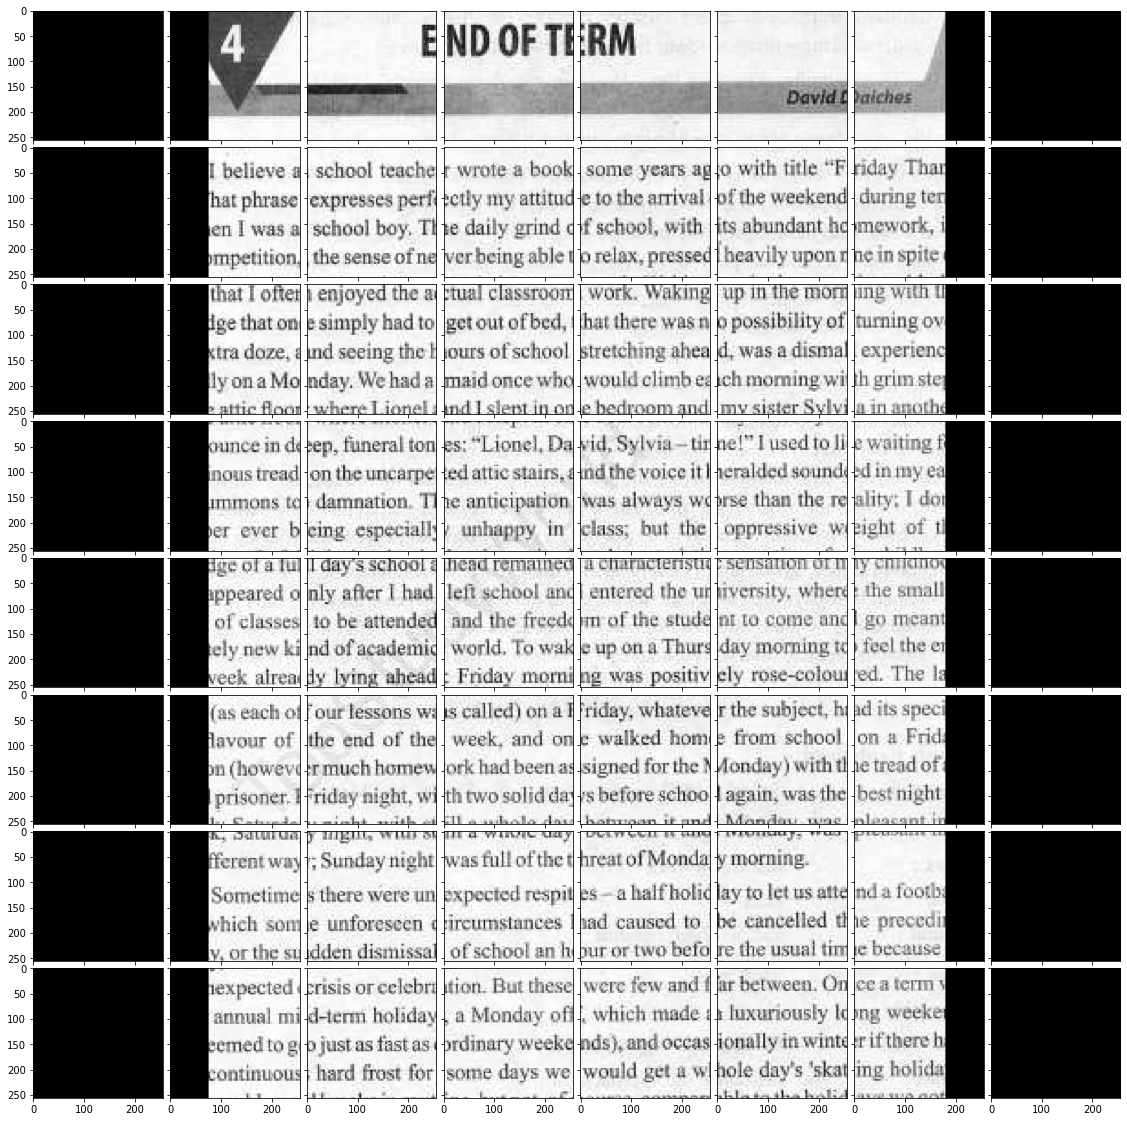

In [ ]:
plot_grid(img_p)

In [ ]:
from torchvision.utils import save_image
for r_i,r in enumerate(img_p):
  for c_i,c in enumerate(r):
    save_image(c,f'Test_Images/Image {r_i} {c_i}.png')

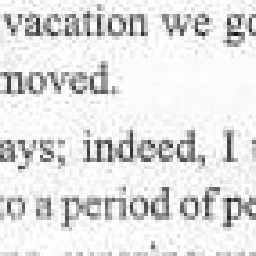

In [ ]:
Image.open('/content/ASTER/Test_Images/Image 0 5.png')

#Just for Testing

In [ ]:
cd '/content/drive/MyDrive/ChangTextSR/26FebOnwar/26febOnNBS/TPL-Loss-Work'

/content/drive/.shortcut-targets-by-id/1J9__WJ-rS1-X0IbbGlVPSfYydhyOm7Sm/ChangTextSR/26FebOnwar/26febOnNBS/TPL-Loss-Work


In [ ]:
import sys
import json

In [ ]:
dataset = {}

In [ ]:
with open("img_text_dict.json",'r') as f:
  dataset = json.load(f)

# **ASTER Module**

### Defining The Arguments for ATER

In [4]:
from ASTER import config
def getArguments(global_args):
  global_args.height = 128
  global_args.width = 128
  global_args.voc_type = 'ALLCASES_SYMBOLS'
  global_args.arch = 'ResNet_ASTER'
  global_args.with_lstm = True
  global_args.STN_ON = True
  global_args.max_len = 20
  global_args.beam_width = 5
  global_args.tps_inputsize = [128,128] 
  global_args.tps_outputsize = [128,128] 
  global_args.tps_margins = [0.05,0.05]
  global_args.stn_activation = 'none'
  global_args.num_control_points = 20 
  global_args.resume = 'ASTER/demo.pth.tar'
  global_args.image_path = ''
  global_args.cuda = True
  return global_args

In [5]:
global_args = config.get_args(sys_args=sys.argv[1:])
args = getArguments(global_args)

### Importing all the Libraries for building ASTER

In [6]:
from __future__ import absolute_import
import sys
sys.path.append('./')

import argparse
import os
import os.path as osp
import numpy as np
import math
import time
from PIL import Image, ImageFile

import torch
from torch import nn, optim
from torch.backends import cudnn
from torch.utils.data import DataLoader
from torchvision import transforms

from ASTER.lib.models.model_builder import ModelBuilder
from ASTER.lib.utils.serialization import load_checkpoint
from ASTER.lib.evaluation_metrics.metrics import get_str_list
from ASTER.lib.utils.labelmaps import get_vocabulary, labels2strs
from ASTER.config import get_args

global_args = get_args(sys.argv[1:])

### Helper function for pre-processing the Image and Dictionary for ASTER

In [7]:
def image_process(image_path, imgH=128, imgW=128, keep_ratio=False, min_ratio=1):
  img = Image.open(image_path).convert('RGB')
  print(img)
  if keep_ratio:
    w, h = img.size
    ratio = w / float(h)
    imgW = int(np.floor(ratio * imgH))
    imgW = max(imgH * min_ratio, imgW)

  img = img.resize((imgW, imgH), Image.BILINEAR)
  img = transforms.ToTensor()(img)
  img.sub_(0.5).div_(0.5)

  return img

class DataInfo(object):
  """
  Save the info about the dataset.
  This a code snippet from dataset.py
  """
  def __init__(self, voc_type):
    super(DataInfo, self).__init__()
    self.voc_type = voc_type

    assert voc_type in ['LOWERCASE', 'ALLCASES', 'ALLCASES_SYMBOLS']
    self.EOS = 'EOS'
    self.PADDING = 'PADDING'
    self.UNKNOWN = 'UNKNOWN'
    self.voc = get_vocabulary(voc_type, EOS=self.EOS, PADDING=self.PADDING, UNKNOWN=self.UNKNOWN)
    self.char2id = dict(zip(self.voc, range(len(self.voc))))
    self.id2char = dict(zip(range(len(self.voc)), self.voc))

    self.rec_num_classes = len(self.voc)

### Function to build the ASTER

In [8]:
def buildAster(args):
  np.random.seed(args.seed)
  torch.manual_seed(args.seed)
  torch.cuda.manual_seed(args.seed)
  torch.cuda.manual_seed_all(args.seed)
  cudnn.benchmark = True
  torch.backends.cudnn.deterministic = True

  args.cuda = args.cuda and torch.cuda.is_available()
  if args.cuda:
    print('using cuda.')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
  else:
    torch.set_default_tensor_type('torch.FloatTensor')
  
  # Create data loaders
  if args.height is None or args.width is None:
    args.height, args.width = (128, 128)
  dataset_info = DataInfo(args.voc_type)
  # Create model
  model = ModelBuilder(arch=args.arch, rec_num_classes=dataset_info.rec_num_classes,
                       sDim=args.decoder_sdim, attDim=args.attDim, max_len_labels=args.max_len,
                       eos=dataset_info.char2id[dataset_info.EOS], STN_ON=args.STN_ON)

  # Load from checkpoint
  if args.resume:
    model_dict = torch.load(args.resume)
    model.load_state_dict(model_dict['state_dict'])

  if args.cuda:
    device = torch.device("cuda")
    model = model.to(device)
    #model = nn.DataParallel(model)
  return model


### Run the below cell to build the ASTER with given args [**GPU**]

In [9]:
model = buildAster(args)

using cuda.


### Random Jargon [Not Needed]

In [ ]:
img_path = list(dataset['files'].keys())[5]

In [ ]:
label = dataset['files'][img_path]

In [ ]:
args.image_path = img_path
image_process(args.image_path).numpy().shape

### Used for creating the dataset- [Not needed]

In [ ]:
new_dataset = {}
files = {}

In [ ]:
def create_targets(dataset,args):
  for img_path in dataset['files'].keys():
    target = dataset['files'][img_path]
    new_target = []
    for char in target['plain_target']:
      if (char=='—' ):
        targ = dataset_info.char2id['-']
      elif (char == '“' or char=='”'):
        targ = dataset_info.char2id['"']
      else:
        targ = dataset_info.char2id[char]
      new_target.append(targ)
    
    rec_targets = torch.tensor([dataset_info.char2id[dataset_info.EOS]]*args.max_len)
    target_len = min(len(new_target),args.max_len)
    rec_targets[:target_len] = torch.tensor(new_target[:target_len])
    rec_targets[args.max_len-1] = dataset_info.char2id[dataset_info.EOS]
    rec_targets = list(rec_targets.detach().cpu().numpy())
    rec_targets = list(map(int, rec_targets)) 
    values={}
    values['plain_target'] = target['plain_target']
    values['rec_targets'] = rec_targets
    files[img_path] = values
  return files

In [ ]:
files = create_targets(dataset,args)

In [ ]:
new_dataset['files'] = files
with open("image_text_dict.json",'w') as jsonfile:
  json.dump(new_dataset,jsonfile)

### Function to **run the ASTER model** for predicting the text

In [10]:
dataset_info = DataInfo(args.voc_type)

In [11]:
device = torch.device("cuda")

In [12]:
args.max_len

20

In [13]:
def predict_aster(aster_model,image_path,args):
    model = aster_model.eval()
    args.image_path = image_path
    img = image_process(args.image_path)
    device = torch.device("cuda")
    dataset_info = DataInfo(args.voc_type)
    with torch.no_grad():
      img = img.to(device)
    input_dict = {}
    input_dict['images'] = img.unsqueeze(0).to(device)
    input_dict['rec_targets'] = torch.IntTensor(1, args.max_len).fill_(1).to(device)
    input_dict['rec_lengths'] = [args.max_len]
    output_dict = model(input_dict)
    pred_rec = output_dict['output']['pred_rec']
    pred_str, _ = get_str_list(pred_rec, input_dict['rec_targets'], dataset=dataset_info)
    predicted_word = pred_str 
    return output_dict, predicted_word

### Loading the Dataset and testing the Model


In [14]:
dataset = {}
with open('image_text_dict.json','r') as f:
    dataset = json.load(f)

In [15]:
#testing for a sample image
#To get path of each image
img_path = list(dataset['files'].keys())

plain_text = dataset['files'][img_path[129]]['plain_target']

know


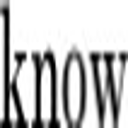

In [16]:
print(plain_text)
Image.open(img_path[129])

In [ ]:
output_dict,pred_text = predict_aster(model,
                                      img_path[129],args)

In [18]:
pred_text

['know']

In [20]:
output_dict['losses']

{}

In [21]:
out_dic = output_dict['output']['pred_logits']

In [22]:
from torch import nn

In [23]:
criterion = torch.nn.CrossEntropyLoss()

In [24]:
def encode_text_batch(text_batch):
    
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [dataset_info.char2id[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets.type(torch.long).to(device), text_batch_targets_lens

In [25]:
import torch.nn.functional as F

In [26]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    #text_batch_logps = F.log_softmax(text_batch_logits, 2)

    # text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
    #                                    fill_value=text_batch_logps.size(0), 
    #                                    dtype=torch.int32).to(device) # [batch_size] 
    
    #text_batch_logps = torch.argmax(text_batch_logps,2)
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    text_batch_logps_new = text_batch_logits[:,:text_batch_targets_lens]
    loss = criterion(text_batch_logps_new.squeeze(0),text_batch_targets)

    # for id in temp:
    #   print(dataset_info.id2char[int(id[0])])
    # print(text_batch_logps)
    # print('a')
    # print(text_batch_logps_lens) 
    # # text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    # print(text_batch_targets)
    # print(text_batch_targets_lens)
    # loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [27]:
loss = compute_loss(["cmow"],out_dic)

In [28]:
loss

tensor(13.3433, grad_fn=<NllLossBackward>)

In [29]:
output_dict['losses']

{}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


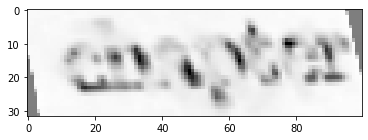

In [ ]:
plt.imshow(
    output_dict['output']['rectified_images'].squeeze(0).
    detach().cpu().numpy().transpose(1,2,0))

In [ ]:
pred_text

['electer']

In [ ]:

new_target = []
for char in "chapter":
    if (char=='—' ):
        targ = dataset_info.char2id['-']
    elif (char == '“' or char=='”'):
      targ = dataset_info.char2id['"']
    else:
      targ = dataset_info.char2id[char]
    new_target.append(targ)

rec_targets = torch.tensor([dataset_info.char2id[dataset_info.EOS]]*args.max_len)
#rec_targets = torch.tensor([1]*args.max_len)
target_len = min(len(new_target),args.max_len)
rec_targets[:target_len] = torch.tensor(new_target[:target_len])
rec_targets[args.max_len-1] = dataset_info.char2id[dataset_info.EOS]
rec_targets = list(rec_targets.detach().cpu().numpy())
rec_targets = list(map(int, rec_targets)) 


In [ ]:
rec_targets

In [ ]:
dataset_info.char2id

{'!': 62,
 '"': 63,
 '#': 64,
 '$': 65,
 '%': 66,
 '&': 67,
 "'": 68,
 '(': 69,
 ')': 70,
 '*': 71,
 '+': 72,
 ',': 73,
 '-': 74,
 '.': 75,
 '/': 76,
 '0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 ':': 77,
 ';': 78,
 '<': 79,
 '=': 80,
 '>': 81,
 '?': 82,
 '@': 83,
 'A': 36,
 'B': 37,
 'C': 38,
 'D': 39,
 'E': 40,
 'EOS': 94,
 'F': 41,
 'G': 42,
 'H': 43,
 'I': 44,
 'J': 45,
 'K': 46,
 'L': 47,
 'M': 48,
 'N': 49,
 'O': 50,
 'P': 51,
 'PADDING': 95,
 'Q': 52,
 'R': 53,
 'S': 54,
 'T': 55,
 'U': 56,
 'UNKNOWN': 96,
 'V': 57,
 'W': 58,
 'X': 59,
 'Y': 60,
 'Z': 61,
 '[': 84,
 '\\': 85,
 ']': 86,
 '^': 87,
 '_': 88,
 '`': 89,
 'a': 10,
 'b': 11,
 'c': 12,
 'd': 13,
 'e': 14,
 'f': 15,
 'g': 16,
 'h': 17,
 'i': 18,
 'j': 19,
 'k': 20,
 'l': 21,
 'm': 22,
 'n': 23,
 'o': 24,
 'p': 25,
 'q': 26,
 'r': 27,
 's': 28,
 't': 29,
 'u': 30,
 'v': 31,
 'w': 32,
 'x': 33,
 'y': 34,
 'z': 35,
 '{': 90,
 '|': 91,
 '}': 92,
 '~': 93}

# Using ASTER as a loss, for SR

In [ ]:
from torch.utils.data import Dataset, DataLoader


In [ ]:

class CAPTCHADataset(Dataset):
    
    def __init__(self, data_dir, image_fns):
        self.data_dir = data_dir
        self.image_fns = image_fns
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        #text = image_fn.split(".")[0]
        text = image_fn[:-4]
        return image, text
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.Resize((64,200)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)
